# Ceng 798 - Quantum Computing Project
## Grover's Algorithm for String Matching
### Mert Tunc - 2023 Spring


In this project, we will implement [Grover's algorithm](https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm) for string matching. The problem is defined as follows:
Given a string $w$ of length $n$ and a pattern $p$ of length $m$, find all the starting positions of $p$ in $w$.

In the linerature, there are three papers claiming they solved the string matching problem with the help of Grover's algorithm. The first one is [1] and the second one is [2]. In this project, I tried to implement a simler and a novel way of solving the string matching problem with the Grover's algorithm.

[1] https://doi.org/10.1038/s41534-021-00369-3
[2] https://www.sciencedirect.com/science/article/pii/S1570866703000108

So first, let us define the imports we'll use,

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import IBMQ

provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2023-06-07 12:12:15,078: Credentials are already in use. The existing account in the session will be replaced.


And define the variables we'll use,
as in the original statement, we have $w$ and $p$ as the string and the pattern respectively.

In the implementation, it is assumed that the $n$ and $m$ have a length of power 2

In [43]:
inp_w = "1101"
inp_p = "01"

In [44]:
n = len(inp_w)
m = len(inp_p)

In [45]:
assert n >= m, "n must be greater than m"
assert m >= 1, "m must be greater than 0"
assert 2 ** int(math.log2(n)) == n, "n must be a power of 2"
assert 2 ** int(math.log2(m)) == m, "m must be a power of 2"

Grover's algorithm shares a framework with us on how to implement unstructured search with a time complexity of $O(\sqrt{n})$

The framework is as follows:
- Initialize the state $|s\rangle$ to a uniform superposition of all possible states.
- Repeat the following steps $O(\sqrt{n})$ times:
    - Apply the oracle $U_f$ to the state $|s\rangle$.
    - Apply the diffusion operator $U_s$ to the state $|s\rangle$.
- Measure the state $|s\rangle$.

Following image is an illustration of the steps of Grover's Algorithm
![Grovers Illustration](assets/grover_circuit_high_level.png)


In our case, the state we'll be searching will consist of the indexes of the string $w$.
In these indexes, we'll be searching for the pattern $p$.

For example, when we are  $w = 1101$ and $p = 01$,

In [46]:
def list_to_chunks(l, chunk_size):
    for i in range(0, len(l) // chunk_size):
        st = i * chunk_size
        ed = (i + 1) * chunk_size
        yield l[st:ed]


def set_inputs(qc, inp_w, inp_p):
    for i, c in enumerate(inp_w):
        if c == "1":
            qc.x(w[i])

    for i, c in enumerate(inp_p):
        if c == "1":
            qc.x(p[i])


def initialize_s(qc):
    """Apply a H-gate to 'qubits' in qc"""
    qc.h(s_list)

In [47]:
def oracle(qc: QuantumCircuit, start_pos):
    # if the start_pos'th bit is equal on w and p, then increase
    format_string = "{:0" + str(len(s_chunks[0])) + "b}"
    pos_in_binary = format_string.format(start_pos)
    qc.barrier(label=f"start {pos_in_binary}")
    for offset, s in enumerate(s_chunks):
        pos_in_binary = format_string.format(start_pos + offset)

        # for k, pos in enumerate(pos_in_binary):  # 10
        flipped_s = []
        flipped_w = []
        flipped_p = []

        # Here, we would need a anc line to or the cases then the s1 should be 1
        # there are n-m-1 such cases, w0 = p0, w1=p0 ...
        for k, pos in enumerate(pos_in_binary):  # 10
            if pos == "0":
                flipped_s.append(s[k])
                qc.x(s[k])

        if inp_p[0 + offset] == "0":
            flipped_p.append(p[0 + offset])
            qc.x(p[0 + offset])

            flipped_w.append(w[0 + start_pos + offset])
            qc.x(w[0 + start_pos + offset])

        qc.mcx(list(s) + [w[start_pos + offset], p[0 + offset]], bit_matches[offset])

        # qc.ccz(w[start_pos + offset], p[0 + offset], s[k])

        if len(flipped_w):
            qc.x(flipped_w)
        if len(flipped_p):
            qc.x(flipped_p)
        if len(flipped_s):
            qc.x(flipped_s)
    qc.barrier(label=f"end {pos_in_binary}")

In [48]:
def diffusion(qc: QuantumCircuit):
    """Apply a diffusion circuit to the register 'qubits' in qc"""
    for reg in s_chunks:
        qc.h(reg)
        qc.x(reg)

    qc.mcx(s_list, match)
    qc.z(match)

    for reg in s_chunks:
        qc.x(reg)
        qc.h(reg)

In [49]:
def measurement_s(grover_circuit, num_shots=1000):
    num_bits = len(s_list)
    meas = QuantumCircuit(num_bits, num_bits)
    meas.measure(list(range(num_bits)), list(range(num_bits)))

    backend = provider.backend.ibmq_qasm_simulator  # ibmq_qasm_simulator
    grover_circuit.compose(meas, inplace=True, qubits=s_list)
    result = backend.run(transpile(grover_circuit, backend), shots=num_shots).result()
    counts = result.get_counts(grover_circuit)

    return counts


In [50]:
num_sbits = math.ceil(math.log2(n - m)) + 1

# Number of s'es will be len(m)
# Number of bits in s'es will be num_sbits

s_list = QuantumRegister(num_sbits * m, 's_list')
s_chunks = list(list_to_chunks(s_list, num_sbits))
w = QuantumRegister(n, 'w')
p = QuantumRegister(m, 'p')
bit_matches = QuantumRegister(m, 'bit_matches')
match = QuantumRegister(1, 'match')

qc = QuantumCircuit(s_list, w, p, bit_matches, match)

In [51]:
set_inputs(qc, inp_w, inp_p)
initialize_s(qc)

num_repetitions = int(math.sqrt(2 ** (num_sbits * m)))
print(f"Circuit depth is {num_repetitions}")
for repetition in range(num_repetitions):
    for start_pos in range(n - m + 1):
        oracle(qc, start_pos)
        qc.mcx(bit_matches, match)
        oracle(qc, start_pos)
    diffusion(qc)
counts = measurement_s(qc)

Circuit depth is 4


{'1011': 1, '1001': 5, '0010': 4, '0101': 4, '1100': 5, '0001': 9, '1000': 7, '1101': 913, '0000': 5, '0011': 9, '0111': 5, '1111': 4, '1010': 10, '0110': 9, '0100': 10}


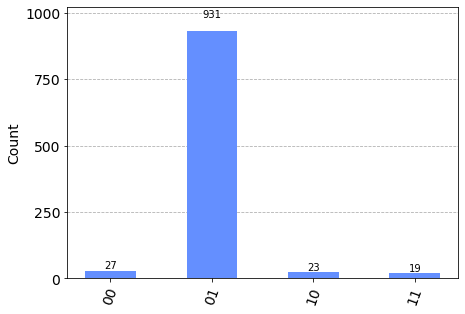

In [52]:
print(counts)
from qiskit.visualization import plot_distribution

%matplotlib inline
def plot_histogram(counts):
    aggregated_counts = {}
    for k, v in counts.items():
        agg_k = k[-num_sbits:]
        if agg_k in aggregated_counts:
            aggregated_counts[agg_k] += v
        else:
            aggregated_counts[agg_k] = v

    return plot_histogram(aggregated_counts)
plot_histogram(counts)